**Investigating Graph Node Embeddings**

Gian Favero | ECSE 556 | December 1st, 2023

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from helpers import *

First we load the .edge file associated with the “HumanNet Co-Expression of Human Genes (hn_HS_CX) network. The file will be cleaned up in such a way that only the relevant columns and values are kept.

In [3]:
edges_df = pd.read_csv('9606.hn_HS_CX.edge', sep='\t', header=None)
edges_df = edges_df.iloc[:, :3]
edges_df.columns = ['Node 1', 'Node 2', 'Weight']
print(edges_df.head())

            Node 1           Node 2    Weight
0  ENSG00000284589  ENSG00000276821  0.000008
1  ENSG00000284589  ENSG00000267534  0.000006
2  ENSG00000284589  ENSG00000178802  0.000006
3  ENSG00000284589  ENSG00000172772  0.000007
4  ENSG00000284589  ENSG00000167751  0.000008


Now we have to start forming the adjacency matrix that represents the network. We can get a set of every node in the network and then augment the dataset to ensure the network is undirected.

In [4]:
# Get set of all nodes
nodes = set(edges_df['Node 1'])
nodes = nodes.union(set(edges_df['Node 2']))

print('Number of nodes:', len(nodes))
print('Number of edges:', len(edges_df))

# Convert nodes to indices in edges_df
nodes_dict = dict(zip(nodes, range(len(nodes))))
edge_id_df = edges_df.copy()
edge_id_df['Node 1'] = edge_id_df['Node 1'].map(nodes_dict)
edge_id_df['Node 2'] = edge_id_df['Node 2'].map(nodes_dict)

# Initialize adjacency matrix
adj_mat = np.zeros((len(nodes), len(nodes)))

# Fill adjacency matrix
for i in tqdm(range(len(edge_id_df))):
    row = edge_id_df.iloc[i]
    adj_mat[int(row['Node 1']), int(row['Node 2'])] = row['Weight']

# If there are any self-loops, remove them
np.fill_diagonal(adj_mat, 0)

Number of nodes: 10938
Number of edges: 154387


100%|██████████| 154387/154387 [00:13<00:00, 11469.53it/s]


In [5]:
# Adjust adjacency matrix to be symmetric, undirected
adj_mat = process_symmetric_entries(adj_mat)

# Find all subgraphs and get list of nodes that belong to subgraphs with less than 5 nodes
subgraphs = find_subgraphs(adj_mat)
nodes_remove = nodes_to_remove(subgraphs, 5)

# Remove nodes from adjacency matrix
adj_mat = np.delete(adj_mat, nodes_remove, axis=0)
adj_mat = np.delete(adj_mat, nodes_remove, axis=1)

# Remove nodes from nodes list
nodes = list(nodes)
nodes = [nodes[i] for i in range(len(nodes)) if i not in nodes_remove]
nodes_dict = dict(zip(nodes, range(len(nodes))))

# Remove rows from edges_df that contain nodes that were removed
edges_df = edges_df[edges_df['Node 1'].isin(nodes)]
edges_df = edges_df[edges_df['Node 2'].isin(nodes)]

edges_df['Node 1'] = edges_df['Node 1'].map(nodes_dict)
edges_df['Node 2'] = edges_df['Node 2'].map(nodes_dict)

# Normalize adjacency matrix by row
tr_mat = adj_mat / adj_mat.sum(axis=1, keepdims=True)

# Print size of network
print('Number of nodes: ', len(nodes))
print('Number of edges: ', len(edges_df))

Number of nodes:  10825
Number of edges:  154328


**RW No Restart**

Now, we initialize three random initial distribution vectors with only one non-zero entry. We run RW until convergence and output the final distributions to see if RW without restart preserves local information about the nodes.

100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Are the vectors close? True
Cosine similarity between vectors: [1.0, 1.0, 1.0]
Pearson correlation between vectors: [1.0, 1.0, 1.0]
Spearman correlation between vectors: [0.9999999999999999, 0.9999999999999999, 0.9999999999999999]


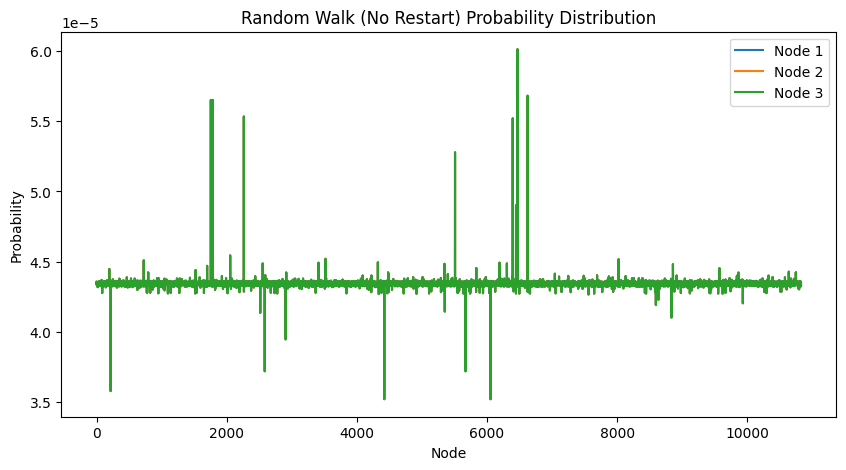

In [6]:
# First random walk vector has only one entry of 1, rest are 0
rw_vec = np.zeros((tr_mat.shape[0], 1))
rw_vec1 = rw_vec
rw_vec1[0] = 1

rw_vec2 = rw_vec
rw_vec2[1500] = 1

rw_vec3 = rw_vec
rw_vec3[5000] = 1

vecs = [rw_vec1, rw_vec2, rw_vec3]

# Perform random walk until there is small change in vector
stat_dist_no_restart = []
eps = 1e-5
for vec in tqdm(vecs):
    while True:
        rw_vec_new = tr_mat @ vec
        if np.linalg.norm(rw_vec_new - vec) < eps:
            break
        vec = rw_vec_new
    stat_dist_no_restart.append(rw_vec_new)

# See if the vectors are equal
are_close = np.allclose(stat_dist_no_restart[0], stat_dist_no_restart[1]) and \
            np.allclose(stat_dist_no_restart[0], stat_dist_no_restart[2]) and \
            np.allclose(stat_dist_no_restart[1], stat_dist_no_restart[2])
print('Are the vectors close? {}'.format(are_close))

# Get cosine similarity between vectors
cos_sim = []
for i in range(len(stat_dist_no_restart)):
    for j in range(i+1, len(stat_dist_no_restart)):
        dot = np.dot(stat_dist_no_restart[i].T, stat_dist_no_restart[j])[0][0]
        norm1 = np.linalg.norm(stat_dist_no_restart[i])
        norm2 = np.linalg.norm(stat_dist_no_restart[j])
        cos_sim.append(dot / (norm1 * norm2))
print('Cosine similarity between vectors: {}'.format(cos_sim))

# Get Pearson correlation between vectors
pearson_corr = []
for i in range(len(stat_dist_no_restart)):
    for j in range(i+1, len(stat_dist_no_restart)):
        pearson_corr.append(pearsonr(stat_dist_no_restart[i].flatten(), stat_dist_no_restart[j].flatten())[0])
print('Pearson correlation between vectors: {}'.format(pearson_corr))

# Get Spearman correlation between vectors
spearman_corr = []
for i in range(len(stat_dist_no_restart)):
    for j in range(i+1, len(stat_dist_no_restart)):
        spearman_corr.append(spearmanr(stat_dist_no_restart[i].flatten(), stat_dist_no_restart[j].flatten())[0])
print('Spearman correlation between vectors: {}'.format(spearman_corr))

# Graph the three vectors stacked on top of each other
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(stat_dist_no_restart[0], label='Node 1')
plt.plot(stat_dist_no_restart[1], label='Node 2')
plt.plot(stat_dist_no_restart[2], label='Node 3')
plt.legend()
plt.xlabel('Node')
plt.ylabel('Probability')
plt.title('Random Walk (No Restart) Probability Distribution')
plt.show()

**RW with Restart**

Now, we do a similar procedure as before but this time there is a chance on every iteration that the walk restarts from the beginning of its walk.

In [8]:
# Assign the restart nodes
N1 = int(edges_df['Node 1'].iloc[0])
v_N1 = np.zeros((tr_mat.shape[0], 1))
v_N1[N1] = 1

N2 = int(edges_df['Node 2'].iloc[0])
v_N2 = np.zeros((tr_mat.shape[0], 1))
v_N2[N2] = 1

Starting from an initial distribution, q0, we can find the stationary distribution when N1 and N2 are the restart set at different values of p

In [9]:
# Make list of p
p = [0.2, 0.5, 0.8]

# Make random initial distribution
q = np.zeros((tr_mat.shape[0], 1))
q[0] = 1

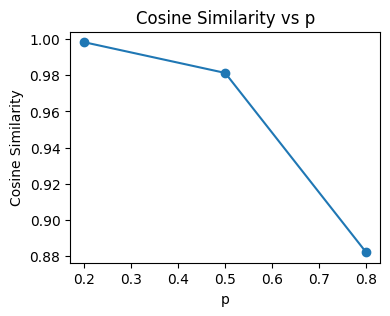

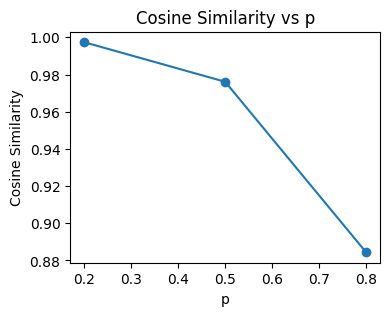

In [10]:
import matplotlib.pyplot as plt

for index, node in enumerate([v_N1, v_N2]):
    eps = 1e-5
    vec = q
    stat_dist_restart = []

    for p_i in p:
        while True:
            rw_vec_new = p_i * tr_mat @ vec + (1 - p_i) * node
            if np.linalg.norm(rw_vec_new - vec) < eps:
                break
            vec = rw_vec_new
        stat_dist_restart.append(rw_vec_new)

    # Put stationary distributions into a dataframe
    stat_dist_restart_df = pd.DataFrame(np.hstack(stat_dist_restart))
    stat_dist_restart_df.insert(0, 'Node', nodes)
    stat_dist_restart_df.columns = ['Node', 'p = 0.2', 'p = 0.5', 'p = 0.8']

    # Save stationary distributions to csv
    stat_dist_restart_df.to_csv(f'stationary/stat_dist_p_{index}.csv', index=False)

    # Compare stationary distributions to restart node 
    # Get cosine similarity between stationary distributions and restart node
    cos_sim = []
    for i in range(len(stat_dist_restart)):
        dot = np.dot(stat_dist_restart[i].T, node)
        norm1 = np.linalg.norm(stat_dist_restart[i])
        norm2 = np.linalg.norm(node)
        cosine_similarity = dot / (norm1 * norm2)
        cos_sim.append(cosine_similarity.item())

    # Plot cosine similarity vs p
    plt.figure(figsize=(4, 3))
    plt.plot(p, cos_sim, '-o')
    plt.xlabel('p')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity vs p')
    plt.show()

We can also observe what happens when a different initial distribution is picked but p is held fixed 

In [11]:
# Enforce constant p
p_fixed = 0.2

# Make 3 random initial distributions
q1 = np.zeros((tr_mat.shape[0], 1))
q2 = np.zeros((tr_mat.shape[0], 1))
q3 = np.zeros((tr_mat.shape[0], 1))

q1[0] = 1
q2[1500] = 1
q3[5000] = 1

qs = [q1, q2, q3]

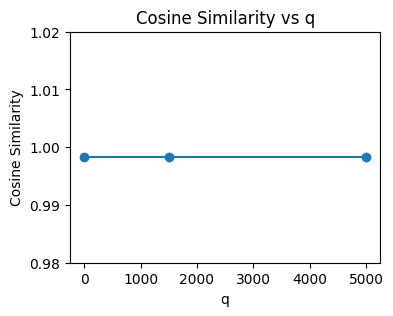

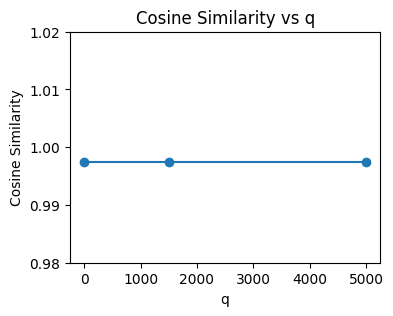

In [12]:
import matplotlib.pyplot as plt

for index, node in enumerate([v_N1, v_N2]):
    eps = 1e-5
    stat_dist_restart = []

    for q_i in qs:
        vec = q_i
        while True:
            rw_vec_new = p_fixed * tr_mat @ vec + (1 - p_fixed) * node
            if np.linalg.norm(rw_vec_new - vec) < eps:
                break
            vec = rw_vec_new
        stat_dist_restart.append(rw_vec_new)

    # Compare stationary distributions to restart node 
    # Get cosine similarity between stationary distributions and restart node
    cos_sim = []
    for i in range(len(stat_dist_restart)):
        dot = np.dot(stat_dist_restart[i].T, node)
        norm1 = np.linalg.norm(stat_dist_restart[i])
        norm2 = np.linalg.norm(node)
        cosine_similarity = dot / (norm1 * norm2)
        cos_sim.append(cosine_similarity.item())
    
    # Plot cosine similarity vs q
    plt.figure(figsize=(4, 3))
    plt.plot([0, 1500, 5000], cos_sim, '-o')
    plt.xlabel('q')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity vs q')
    plt.ylim(0.98, 1.02)
    plt.show()

Last, we can analyze the benefits of restart. Are the stationary distributions generated using N1 and N2 the same as they were with no restart?

In [13]:
# Enforce constant p
p_fixed = 0.2

# Enforce a random initial distribution
q_fixed = np.zeros((tr_mat.shape[0], 1))
q_fixed[0] = 1

In [14]:
eps = 1e-5
stat_dist_restart = []
vec = q_fixed

for index, node in enumerate([v_N1, v_N2]):
    while True:
        rw_vec_new = p_fixed * tr_mat @ vec + (1 - p_fixed) * node
        if np.linalg.norm(rw_vec_new - vec) < eps:
            break
        vec = rw_vec_new
    stat_dist_restart.append(rw_vec_new)

# Check if stationary distributions are equal
are_close = np.allclose(stat_dist_restart[0], stat_dist_restart[1])
print('Are the stationary distributions close? {}'.format(are_close))

# Get cosine similarity between stationary distributions
dot = np.dot(stat_dist_restart[0].T, stat_dist_restart[1])
norm1 = np.linalg.norm(stat_dist_restart[0])
norm2 = np.linalg.norm(stat_dist_restart[1])
cosine_similarity = dot / (norm1 * norm2)
print('Cosine similarity between stationary distributions: {}'.format(cosine_similarity[0][0]))

# Get cosine similarity between stationary distributions and restart node 1
for i in range(2):
    dot = np.dot(stat_dist_restart[i].T, v_N1)
    norm1 = np.linalg.norm(stat_dist_restart[i])
    norm2 = np.linalg.norm(v_N1)
    cosine_similarity = dot / (norm1 * norm2)
    print('Cosine similarity between stationary distribution {} and restart node 1: {}'.format(i, cosine_similarity[0][0]))

# Get cosine similarity between stationary distributions and restart node 2
for i in range(2):
    dot = np.dot(stat_dist_restart[i].T, v_N2)
    norm1 = np.linalg.norm(stat_dist_restart[i])
    norm2 = np.linalg.norm(v_N2)
    cosine_similarity = dot / (norm1 * norm2)
    print('Cosine similarity between stationary distribution {} and restart node 2: {}'.format(i, cosine_similarity[0][0]))

Are the stationary distributions close? False
Cosine similarity between stationary distributions: 0.024595834442104007
Cosine similarity between stationary distribution 0 and restart node 1: 0.9982520705995036
Cosine similarity between stationary distribution 1 and restart node 1: 0.010633973572939624
Cosine similarity between stationary distribution 0 and restart node 2: 0.010944159251964621
Cosine similarity between stationary distribution 1 and restart node 2: 0.9973709129921529


**Node2Vec**

We now get embeddings from a Node2Vec implementation

In [31]:
'''import networkx as nx
import node2vec

# Create graph from adjacency matrix
G = nx.from_numpy_matrix(adj_mat)

# Get ranges of p and q to try
node_p = [0.5, 2, 4]
node_q = [0.5, 2, 4]

# Create list of node2vec models
node2vec_models = []
for p in node_p:
    for q in node_q:
        walk = node2vec.Node2Vec(G, p=p, q=q, workers=10)
        model = walk.fit()
        node2vec_models.append(model)

# Save node2vec models
for index, model in enumerate(node2vec_models):
    model.wv.save_word2vec_format(f'node2vec/node2vec_model_{index}.bin')'''

import networkx as nx
import node2vec

# Create graph from adjacency matrix
G = nx.from_numpy_array(adj_mat)

p = 0.5
q = 4
walk = node2vec.Node2Vec(G, p=p, q=q, workers=8)
model = walk.fit()
model.wv.save_word2vec_format(f'node2vec/node2vec_model.bin')

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:14<00:00, 14.00s/it]


In [36]:
from gensim.models import Word2Vec

# Load node2vec models
depth_first_model = Word2Vec.load('node2vec/node2vec_model_2.bin')
breadth_first_model = Word2Vec.load('node2vec/node2vec_model_6.bin')

In [42]:
# Get depth-first embeddings for first two nodes
N1_depth_e = depth_first_model.wv[N1]
N2_depth_e = depth_first_model.wv[N2]

# Get breadth-first embeddings for first two nodes
N1_breadth_e = breadth_first_model.wv[N1]
N2_breadth_e = breadth_first_model.wv[N2]

n1_embeddings = [N1_depth_e, N1_breadth_e]
n2_embeddings = [N2_depth_e, N2_breadth_e]

# Get Pearsons
n1_pearsons = []
n2_pearsons = []
for i in range(len(n1_embeddings)):
    for j in range(i + 1, len(n1_embeddings)):
        pearson = pearsonr(n1_embeddings[i], n1_embeddings[j])
        n1_pearsons.append(pearson[0])
        pearson = pearsonr(n2_embeddings[i], n2_embeddings[j])
        n2_pearsons.append(pearson[0])

# Get Spearmans
n1_spearmans = []
n2_spearmans = []
for i in range(len(n1_embeddings)):
    for j in range(i + 1, len(n1_embeddings)):
        spearman = spearmanr(n1_embeddings[i], n1_embeddings[j])
        n1_spearmans.append(spearman[0])
        spearman = spearmanr(n2_embeddings[i], n2_embeddings[j])
        n2_spearmans.append(spearman[0])

# Get cosine similarities
n1_cos_sim = []
n2_cos_sim = []
for i in range(len(n1_embeddings)):
    for j in range(i + 1, len(n1_embeddings)):
        dot = np.dot(n1_embeddings[i].T, n1_embeddings[j])
        norm1 = np.linalg.norm(n1_embeddings[i])
        norm2 = np.linalg.norm(n1_embeddings[j])
        cosine_similarity = dot / (norm1 * norm2)
        n1_cos_sim.append(cosine_similarity.item())
        dot = np.dot(n2_embeddings[i].T, n2_embeddings[j])
        norm1 = np.linalg.norm(n2_embeddings[i])
        norm2 = np.linalg.norm(n2_embeddings[j])
        cosine_similarity = dot / (norm1 * norm2)
        n2_cos_sim.append(cosine_similarity.item())

# Print results
print('Node 1')
print('Pearson: {}'.format(n1_pearsons))
print('Spearman: {}'.format(n1_spearmans))
print('Cosine Similarity: {}'.format(n1_cos_sim))

print('\nNode 2')
print('Pearson: {}'.format(n2_pearsons))
print('Spearman: {}'.format(n2_spearmans))
print('Cosine Similarity: {}'.format(n2_cos_sim))

# Get similarities between Node 1 and Node 2 embeddings
n1_n2_pearsons = []
n1_n2_spearmans = []
n1_n2_cos_sim = []

for i in range(len(n1_embeddings)):
    for j in range(len(n2_embeddings)):
        pearson = pearsonr(n1_embeddings[i], n2_embeddings[j])
        n1_n2_pearsons.append(pearson[0])
        spearman = spearmanr(n1_embeddings[i], n2_embeddings[j])
        n1_n2_spearmans.append(spearman[0])
        dot = np.dot(n1_embeddings[i].T, n2_embeddings[j])
        norm1 = np.linalg.norm(n1_embeddings[i])
        norm2 = np.linalg.norm(n2_embeddings[j])
        cosine_similarity = dot / (norm1 * norm2)
        n1_n2_cos_sim.append(cosine_similarity.item())

# Print results for Pearson
print('\nNode 1 vs Node 2')
print('Pearson: {}'.format(n1_n2_pearsons))
print('Spearman: {}'.format(n1_n2_spearmans))

Node 1
Pearson: [0.1788469936948812]
Spearman: [0.1593744277604834]
Cosine Similarity: [0.18212565779685974]

Node 2
Pearson: [0.21175808266915055]
Spearman: [0.1529424555942135]
Cosine Similarity: [0.2123740315437317]

Node 1 vs Node 2
Pearson: [0.16980877640947578, 0.05090468335706022, 0.008282422514558496, 0.11049859575375744]
Spearman: [0.1272603460904596, 0.024829472624061523, -0.0030328694378318984, 0.10672266984068851]


We can graph the embeddings of N1 and N2 @ various values of p and q to see how these values make the embeddings more or less distinguished

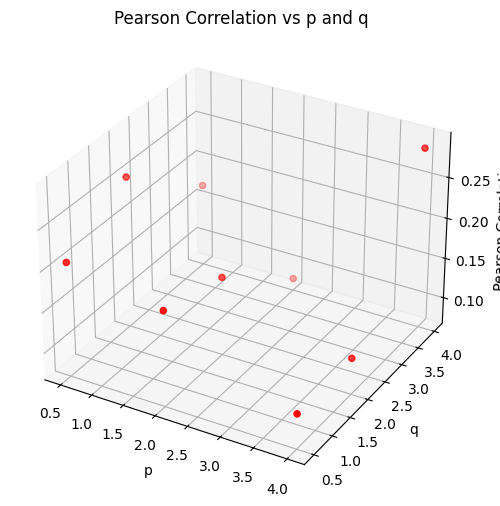

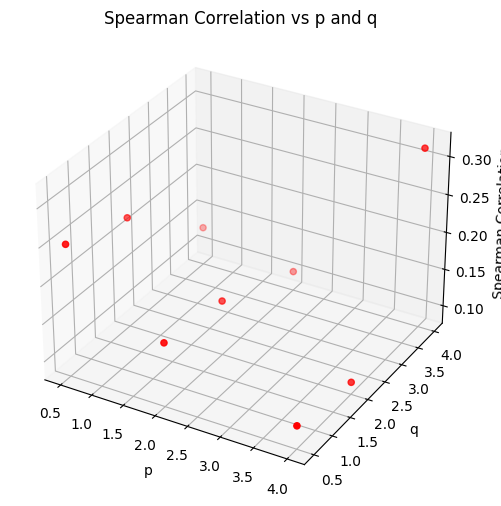

     p    q   Pearson  Spearman
0  0.5  0.5  0.207871  0.250647
1  0.5  2.0  0.253895  0.223133
2  0.5  4.0  0.169809  0.127260
3  2.0  0.5  0.185039  0.160713
4  2.0  2.0  0.164248  0.148679
5  2.0  4.0  0.082270  0.101922
6  4.0  0.5  0.110499  0.106723
7  4.0  2.0  0.112193  0.092056
8  4.0  4.0  0.289353  0.314961


In [38]:
p_values = [0.5, 0.5, 0.5, 2, 2, 2, 4, 4, 4]
q_values = [0.5, 2, 4, 0.5, 2, 4, 0.5, 2, 4]

node2vec_models = []
for i in range(9):
    node2vec_models.append(Word2Vec.load(f'node2vec/node2vec_model_{i}.bin'))

# Get pearson correlation between embeddings of N1 and N2 for each model
pearson_map = []
for model in node2vec_models:
    pearson = pearsonr(model.wv[N1], model.wv[N2])[0]
    pearson_map.append(pearson)

# Get spearman correlation between embeddings of N1 and N2 for each model
spearman_map = []
for model in node2vec_models:
    spearman = spearmanr(model.wv[N1], model.wv[N2])[0]
    spearman_map.append(spearman)

# Plot 2 3D scatter plots of embeddings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# x-axis: p, y-axis: q, z-axis: pearson correlation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_values, q_values, pearson_map, c='r', marker='o')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Pearson Correlation')
plt.title('Pearson Correlation vs p and q')
plt.show()

# x-axis: p, y-axis: q, z-axis: spearman correlation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_values, q_values, spearman_map, c='r', marker='o')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Spearman Correlation')
plt.title('Spearman Correlation vs p and q')
plt.show()

# Make table of p, q, pearson, spearman
df = pd.DataFrame({'p': p_values, 'q': q_values, 'Pearson': pearson_map, 'Spearman': spearman_map})
print(df)

**Community Detection**

Using the same network, we can perform a community detection with various algorithms.

In [ ]:
import networkx as nx
import community as community_louvain
from networkx.algorithms import community

import pickle

'''# Define graph
G = nx.from_numpy_matrix(adj_mat)

# Apply Clauset-Newman-Moore algorithm
clauset_newman_communities = list(community.greedy_modularity_communities(G))
clauset_newman_clusters = {f'Community_{i+1}': list(community_set) for i, community_set in enumerate(clauset_newman_communities)}

# Apply Louvain algorithm
partition = community_louvain.best_partition(G)
louvain_clusters = {f'Community_{i+1}': [node for node, community_id in partition.items() if community_id == i] for i in set(partition.values())}

# Apply Girvan-Newman algorithm
girvan_newman_communities = next(community.girvan_newman(G))
girvan_newman_clusters = {f'Community_{i+1}': list(community_set) for i, community_set in enumerate(girvan_newman_communities)}

# Save the clusters to a dictionary
all_clusters = {
    'Clauset_Newman_Moore': clauset_newman_clusters,
    'Louvain': louvain_clusters,
    'Girvan_Newman': girvan_newman_clusters
}

# Save the dictionary to a pickle file
with open('community_clusters.pkl', 'wb') as file:
    pickle.dump(all_clusters, file)'''

print("Community clusters saved to 'community_clusters.pkl'")

Community clusters saved to 'community_clusters.pkl'


In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import pickle

# Load the clusters from the pickle file
with open('Communities/community_clusters.pkl', 'rb') as file:
    all_clusters = pickle.load(file)

'''greedy_clusters = all_clusters['Clauset_Newman_Moore']
greedy_color_map = {node: i for i, cluster in enumerate(greedy_clusters) for node in cluster}'''

louvain_clusters = all_clusters['Louvain']
louvain_color_map = {node: i for i, cluster in enumerate(louvain_clusters) for node in cluster}

girvan_clusters = all_clusters['Girvan_Newman']
girvan_color_map = {node: i for i, cluster in enumerate(girvan_clusters) for node in cluster}

# Draw the graph with different colors for each cluster
pos = nx.spring_layout(G)  # You can use different layout algorithms
plt.figure(figsize=(12, 8))

# Girvan-Newman
plt.subplot(131)
nx.draw(G, pos, node_color=[girvan_color_map[node] for node in G.nodes], with_labels=True, cmap='viridis')
plt.title('Girvan-Newman')

# Greedy Modularity
plt.subplot(132)
nx.draw(G, pos, node_color=[greedy_color_map[node] for node in G.nodes], with_labels=True, cmap='viridis')
plt.title('Greedy Modularity')

# Louvain
plt.subplot(133)
nx.draw(G, pos, node_color=[louvain_color_map[node] for node in G.nodes], with_labels=True, cmap='viridis')
plt.title('Louvain')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 